<a href="https://colab.research.google.com/github/nwekecosmas/Hamoye-Time-Series-Analysis-Forecast/blob/main/StageE_Tag_AlongCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Further Instructions (14-16)
Using the daily sampling rate (sum), divide the data into a train and test set. The last 300 days is your test set and the first (x-300) days is your training set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series modeling using this time column (‘dt’ or ‘ds’) and the global_active_power (or ‘y’). Answer question 14 - 16

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [3]:
old_file = 'household_power_consumption.txt'
new_file = 'household_power_consumption2.txt'

with open(old_file, 'r') as file:
    content = file.read()
    new_content = content.replace(';' , ',')

with open(new_file, 'w') as file:
    file.write(new_content)


df = pd.read_csv(new_file, low_memory=False)
df.tail(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
113605,5/3/2007,14:49:00,4.104,0.000,239.690,17.600,0.000,65.000,0.0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113606 entries, 0 to 113605
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   113606 non-null  object 
 1   Time                   113606 non-null  object 
 2   Global_active_power    113606 non-null  object 
 3   Global_reactive_power  113606 non-null  object 
 4   Voltage                113606 non-null  object 
 5   Global_intensity       113606 non-null  object 
 6   Sub_metering_1         113606 non-null  object 
 7   Sub_metering_2         113606 non-null  object 
 8   Sub_metering_3         113598 non-null  float64
dtypes: float64(1), object(8)
memory usage: 7.8+ MB
None


In [5]:
# Convert Columns (2,3,4,5,6,7) to float using pd.to_numeric

columns_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2' ]
for col in columns_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' will convert non-convertible values to NaN

# Displaying the DataFrame info to verify the column data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113606 entries, 0 to 113605
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   113606 non-null  object 
 1   Time                   113606 non-null  object 
 2   Global_active_power    113598 non-null  float64
 3   Global_reactive_power  113598 non-null  float64
 4   Voltage                113598 non-null  float64
 5   Global_intensity       113598 non-null  float64
 6   Sub_metering_1         113598 non-null  float64
 7   Sub_metering_2         113598 non-null  float64
 8   Sub_metering_3         113598 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.8+ MB
None


In [6]:
df.isnull().values.any()

True

In [7]:
 #Filling missing data by imputation - Forward fill
dff = df.fillna(method= 'ffill' )

dff.isnull().values.any()

False

In [8]:
dff2 = dff.copy()
dff2.tail(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
113605,5/3/2007,14:49:00,4.104,0.0,239.69,17.6,0.0,65.0,0.0


In [9]:
#  merge date and time columns
dff['DateTime'] = pd.to_datetime(dff['Date']+ ' '+ dff['Time']) #  , format='%d/%m/%Y %H:%M:%S'

In [10]:
# Using the daily sampling rate (sum)

dff = dff[['DateTime', 'Global_active_power']]
dff_daily = dff.resample('D', on='DateTime').sum().reset_index()
dff_daily.tail(1)

,DateTime,Global_active_power
351,2007-12-02,1877.61


In [11]:
# Split into train and test sets
# The last 300 days is your test set and the first (x-300) days is your training set
train = dff_daily.iloc[:-300]
test = dff_daily.iloc[-300:]

In [12]:
# Renaming columns to 'ds' and 'y'

train = train.rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})
test = test.rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})

In [13]:
# Initialize and fit the Prophet model

model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx7x39sv/ulzu8_0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx7x39sv/22hykjub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53681', 'data', 'file=/tmp/tmpyx7x39sv/ulzu8_0s.json', 'init=/tmp/tmpyx7x39sv/22hykjub.json', 'output', 'file=/tmp/tmpyx7x39sv/prophet_model5w7fwe4n/prophet_model-20231130003850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:38:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
#predict for the next 3oo days
future = model.make_future_dataframe(periods= 300 ) #freq = 'D'

# Generating predictions
forecast = model.predict(future)

In [15]:
forecast.tail(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
351,2007-12-02,-3908.996493,-4718.457352,-1828.550034,-3909.000212,-3908.992705,577.287875,577.287875,577.287875,577.287875,577.287875,577.287875,0.0,0.0,0.0,-3331.708618


In [16]:
# Displaying few predictions

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2))

            ds         yhat   yhat_lower   yhat_upper
350 2007-12-01 -3494.164279 -4998.922120 -1988.116574
351 2007-12-02 -3331.708618 -4718.457352 -1828.550034


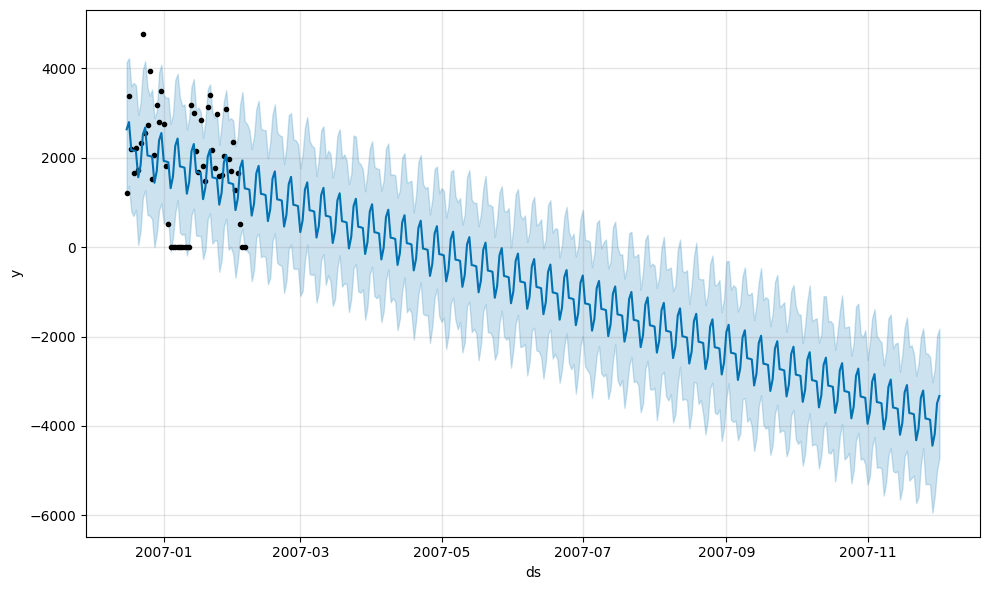

In [17]:
model.plot(forecast)
plt.show()

Further Instructions (17-20) Multivariate Time Series Forecasting with Facebook Prophet

In the last exercise, we used only the dependent variable (Global_Active_Power) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the six independent variables ['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3'] will be [‘add1’, ‘add2’, ‘add3’, ‘add4’, ‘add5’, ‘add6’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last 300 days of the house consumption (‘global_active_power’). Answer questions 17-20:

In [18]:
dff2.tail(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
113605,5/3/2007,14:49:00,4.104,0.0,239.69,17.6,0.0,65.0,0.0


In [19]:
dff2.isnull().values.any()

False

In [20]:
#  merge date and time columns
dff2['DateTime'] = pd.to_datetime(dff2['Date']+ ' '+ dff2['Time'], format='%d/%m/%Y %H:%M:%S')

In [21]:
dff3 = dff2[['DateTime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
dff3.tail(1)

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
113605,2007-03-05 14:49:00,4.104,0.0,239.69,17.6,0.0,65.0,0.0


In [22]:
# preprocessing for facebook prophet for regressors: renaming all the columns

dff4 = dff3.rename(columns={'DateTime' : 'ds', 'Global_active_power': 'y',
                         'Global_reactive_power': 'add1', 'Voltage': 'add2',
                         'Global_intensity': 'add3', 'Sub_metering_1': 'add4',
                         'Sub_metering_2': 'add5', 'Sub_metering_3': 'add6'})
dff4.tail(1)

,ds,y,add1,add2,add3,add4,add5,add6
113605,2007-03-05 14:49:00,4.104,0.0,239.69,17.6,0.0,65.0,0.0


In [23]:
dff4.isnull().values.any()

False

In [24]:
# building a time series model using the other variables.
# other variables are added to the forecast model as a regressor on Facebook Prophet
model_multivariate = Prophet()
model_multivariate.add_regressor('add1')
model_multivariate.add_regressor('add2')
model_multivariate.add_regressor('add3')
model_multivariate.add_regressor('add4')
model_multivariate.add_regressor('add5')
model_multivariate.add_regressor('add6')

In [25]:
# Split into train and test sets
# The last 300 days is your test set and the first (x-300) days is your training set
train_mult = dff4.iloc[:-300]
test_mult = dff4.iloc[-300:]

In [26]:
# training our multivariate model
model_multivariate.fit(train_mult)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx7x39sv/o_82hz6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyx7x39sv/ic12jcs6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49573', 'data', 'file=/tmp/tmpyx7x39sv/o_82hz6h.json', 'init=/tmp/tmpyx7x39sv/ic12jcs6.json', 'output', 'file=/tmp/tmpyx7x39sv/prophet_modelojth7msd/prophet_model-20231130003955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
test_mult.isnull().values.any()

False

In [28]:
# making a prediction with the multivariate model for the next 3oo days
future2 = model_multivariate.make_future_dataframe(periods= 300 )

# Generating predictions
forecast2 = model.predict(future2)

In [29]:
forecast2.tail(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
113605,2007-12-30 09:49:00,-4406.746907,-5585.91782,-2566.869235,-4406.750909,-4406.742971,359.271507,359.271507,359.271507,359.271507,359.271507,359.271507,0.0,0.0,0.0,-4047.4754


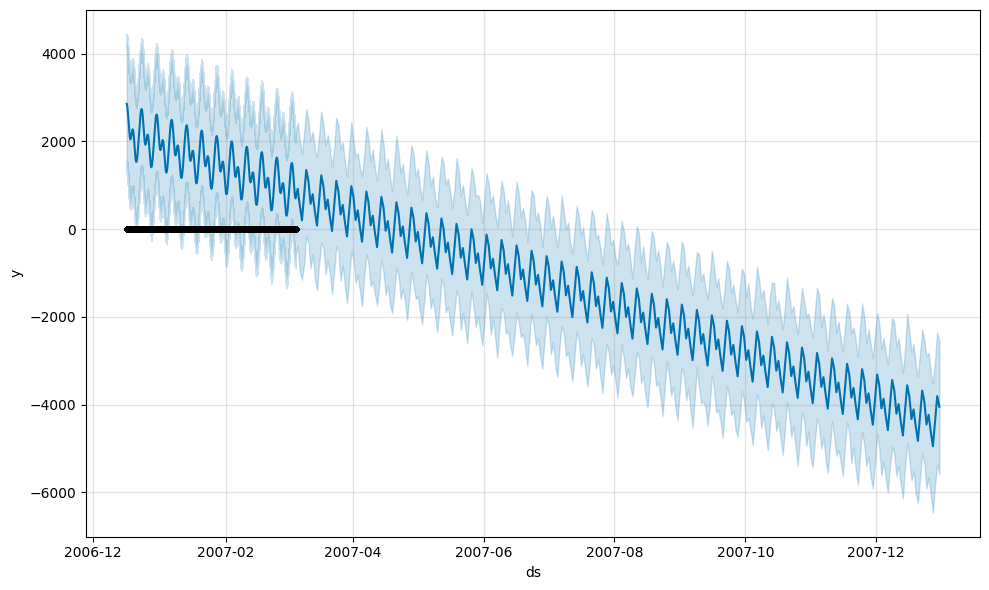

In [30]:
model_multivariate.plot(forecast2)
plt.show()